In [255]:
import sys
sys.path.append("./../..")

from InternalLibrary.StatisticalFunctions import *
from InternalLibrary.SimulatorPackage import Simulator_noGPU

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from tqdm import tqdm
import _pickle as pickle

from scipy.optimize import curve_fit

In [256]:
dt = 1e-6
Sample_frequency = 25_000 
DeltaT = 1/Sample_frequency  
TotalT = 13
transient = 3
EffectiveT = TotalT - transient

sampled_point_amount = np.int64((EffectiveT)/DeltaT) 
t = np.linspace(0., EffectiveT, sampled_point_amount) 

print("Effective simulation time: %d (s)" % EffectiveT)

Effective simulation time: 10 (s)


In [257]:
# Limits for the parameters (kbT=3.8 pN nm)
prior_limits = {
    "mu_y": [1e4, 140e4],
    "k_y": [1.5e-2, 30e-2],
    "k_int": [1e-3, 6e-3],
    "tau": [2e-2, 20e-2],
    "eps": [0.5, 6],
}

In [258]:
# Dummy call to compile the simulator
theta, theta_torch = get_theta_from_prior(prior_limits, 1)
Simulator_noGPU(0.1, 0.1, 0.5, theta);

As a reference, here's a part of the function we called to compute the summary statistics on cloud. 

```python
def compute_summary_statistics(single_x_trace, single_theta, DeltaT = 1/25e3, TotalT = 10):
    summary_statistics = {}
    t = np.linspace(0., TotalT, single_x_trace.shape[0])
    t_corr = TotalT/20 # Hyperparameter
    
    [...]

    # Autocorrelation
    Cxx = stat_corr_single(single_x_trace, DeltaT)
    idx_corr = where((t>0)*(t<t_corr))[0]
    cxx = Cxx[idx_corr]
    summary_statistics["Cxx"] = cxx  
    
    # S red
    S_red1, S_red2, S_red = stat_s_redx(Cxx, t_corr, t)
    summary_statistics["s_red1"] = S_red1
    summary_statistics["s_red2"] = S_red2
    summary_statistics["s_redx"] = S_red 

    [...]
    
    return summary_statistics
```

In [259]:
def stat_corr_single(single_x_trace, DeltaT):
    '''
    Computes the autocorrelation for a single x trace signal.

    INPUT
    singles_x_trace: single x trace signal
    DeltaT: sampling time
    ((t: time array
    t_corr: maximum time for the correlation))

    OUTPUT
    Cxx: autocorrelation x signal
    '''

    sampled_point_amount = single_x_trace.shape[0]
    #idx_corr = where((t>0)*(t<t_corr))[0]
    Cxx= corr(single_x_trace, single_x_trace, sampled_point_amount, dt=DeltaT) # compute the autocorrellation for each x trace

    return Cxx


def stat_s_redx(Cxx, t_corr, t, mu_x=2.8e4, k_x=6e-3, kbT=3.8):
    '''
    Computes the reduced energy production for a single x trace signal.

    INPUT
    Cxx: autocorrelation signal
    t_corr: maximum time for the correlation
    t: time array
    theta_i: parameters

    OUTPUT
    S_red: reduced x energy production
    '''
    D_x = kbT * mu_x
    
    S1 = cumulative_trapezoid(Cxx, x=t, axis=-1, initial=0)
    S1 = cumulative_trapezoid(S1, x=t, axis=-1, initial=0)
    idx_corr = where((t>0)*(t<t_corr))[0]
    S_red1 = (Cxx[0]-Cxx[idx_corr])/(D_x*t[idx_corr]) # First term in S_red
    S_red2 = ((mu_x*k_x)**2)*S1[idx_corr]/(D_x*t[idx_corr]) # Second term in S_red
    S_red = S_red1 + S_red2 # Compute S_red

    return S_red1, S_red2, S_red

In [260]:
%%time
n_sim = 10
theta, theta_torch = get_theta_from_prior(prior_limits, n_sim)
x_trace, y_trace, f_trace = Simulator_noGPU(dt, DeltaT, TotalT, theta, transient_time = transient)

CPU times: user 31.1 s, sys: 189 ms, total: 31.3 s
Wall time: 31.1 s


In [261]:
print("X_trace shape: ", x_trace.shape)
print("theta shape: ", theta.shape)

X_trace shape:  (10, 249999)
theta shape:  (5, 10, 1)


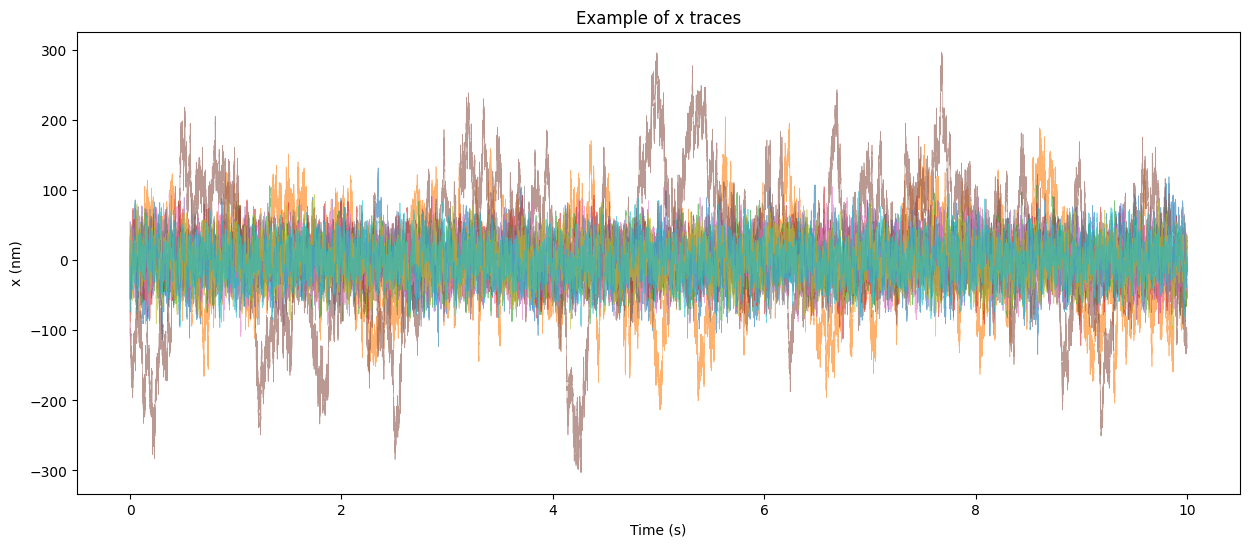

In [262]:
plt.figure(figsize=(15, 6))
plt.title("Example of x traces")
for i in range(n_sim):
    plt.plot(t, x_trace[i], alpha=0.6, lw=0.5)
plt.xlabel("Time (s)")
plt.ylabel("x (nm)");

In [288]:
# Hyperparameters of the statistical functions
## Remember that TotalT does include the transient time
## Note that if t_corr > EffectiveT, idx_corr will be the same as t
t_corr = TotalT/20

# Lists to store the results
Cxx_list = []
s_red1_list = []
s_red2_list = []
s_redx_list = []

# Iterate over the simulations
for i in range(n_sim):
    ## Note that Cxx is cutted after the computation the s_redx
    ## Instead, s_redx is cutted inside stat_ the function
    Cxx = stat_corr_single(x_trace[i], DeltaT)
    
    ## The following line sets Cxx to zero when below a certain threshold
    #Cxx[where(Cxx < 5)[0][0]:] = 0

    idx_corr = where((t>0)*(t<t_corr))[0]
    
    s_red1, s_red2, s_redx = stat_s_redx(Cxx, t_corr, t)
    
    Cxx_list.append(Cxx[idx_corr])
    s_red1_list.append(s_red1)
    s_red2_list.append(s_red2)
    s_redx_list.append(s_redx)

In [282]:
# Define the t_cxx array
t_cxx = t[where((t>0)*(t<t_corr))[0]]
t_cxx[-1]

0.6499651997215978

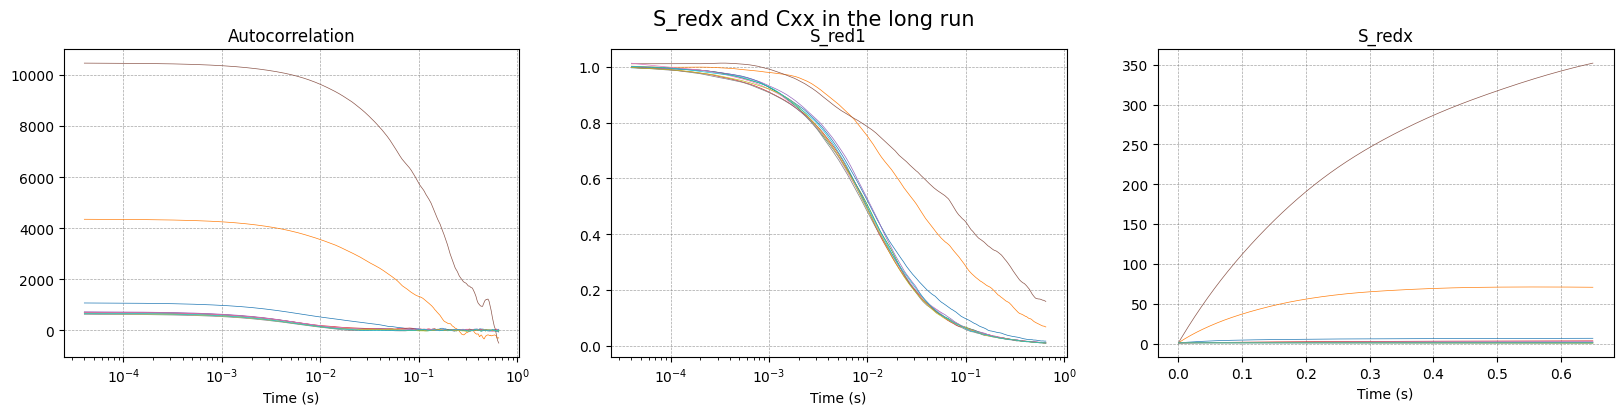

In [283]:
plt.figure(figsize=(20, 4))
plt.suptitle("S_redx and Cxx in the long run", fontsize=15)

plt.subplot(131)
plt.title("Autocorrelation")
for i in range(n_sim):
    plt.plot(t_cxx, Cxx_list[i], alpha=1, lw=0.5)
plt.xlabel("Time (s)")
plt.xscale("log")
#plt.yscale("log")
#plt.xlim(0, 0.9)
#plt.ylim(0, 1000)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

plt.subplot(132)
plt.title("S_red1")
for i in range(n_sim):
    plt.plot(t_cxx, s_red1_list[i], alpha=1, lw=0.5)
plt.xlabel("Time (s)")
plt.xscale("log")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

plt.subplot(133)
plt.title("S_redx")
for i in range(n_sim):
    plt.plot(t_cxx, s_redx_list[i], alpha=1, lw=0.5)
plt.xlabel("Time (s)")
#plt.xscale("log")
#plt.yscale("log")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')


In [295]:
# Function to fit the S_redx
## Note that actually it is s_redx/t to avoid the divergence
def fit_s_redx_simple(t, a, tau):
    return(1 + a*t/(1+t/tau))


def fit_s_redx_exp(t, a1, a2, b1, b2, b3, c):
    a3 = 1 - a1 - a2 
    sum_exp = a1*np.exp(-b1*t) + (a2)*np.exp(-(b1+b2)*t) + (a3)*np.exp(-(b1+b2+b3)*t)
    sum = a1*b1 + (a2)*(b1+b2) + (a3)*(b1+b2+b3)
    tau = 1/sum
    return(1 + c - (c*tau/t)*(1-sum_exp))

## Alternative function (comparable fitting results)
# def fit_s_redx_exp(t, a1, a2, b1, b2, b3, c):
#     a3 = 1 - 3*a1 - 2*a2 
#     sum_exp = a1*np.exp(-b1*t) + (a1+a2)*np.exp(-(b1+b2)*t) + (a1+a2+a3)*np.exp(-(b1+b2+b3)*t)
#     sum = a1*b1 + (a1+a2)*(b1+b2) + (a1+a2+a3)*(b1+b2+b3)
#     tau = 1/sum
#     return(1 + c - (c*tau/t)*(1-sum_exp))

<span style="color:red"> BE CAREFUL: TO TRAIN THE NETWORK YOU SHOULD (probably) SORT [b1, b2, b3] AND MAINTAIN THE CORRESPONDENT [a1, a2] (problem with a3), think about it!!!!!</span>

[0.775712, 9.884475, 7.272551, 46.435433, 0.41268, 6.499746]
[14.349732, 7.648121, 24.555288, 1e-06, 0.423166, 80.033716]
[4.457453, 13.836868, 79.980224, 6.8e-05, 2.089498, 0.597043]
[0.394563, 4.698258, 6.481567, 4e-06, 0.000254, 3.314577]
[0.289489, 3.214956, 6.261254, 2e-06, 0.000553, 1.829103]


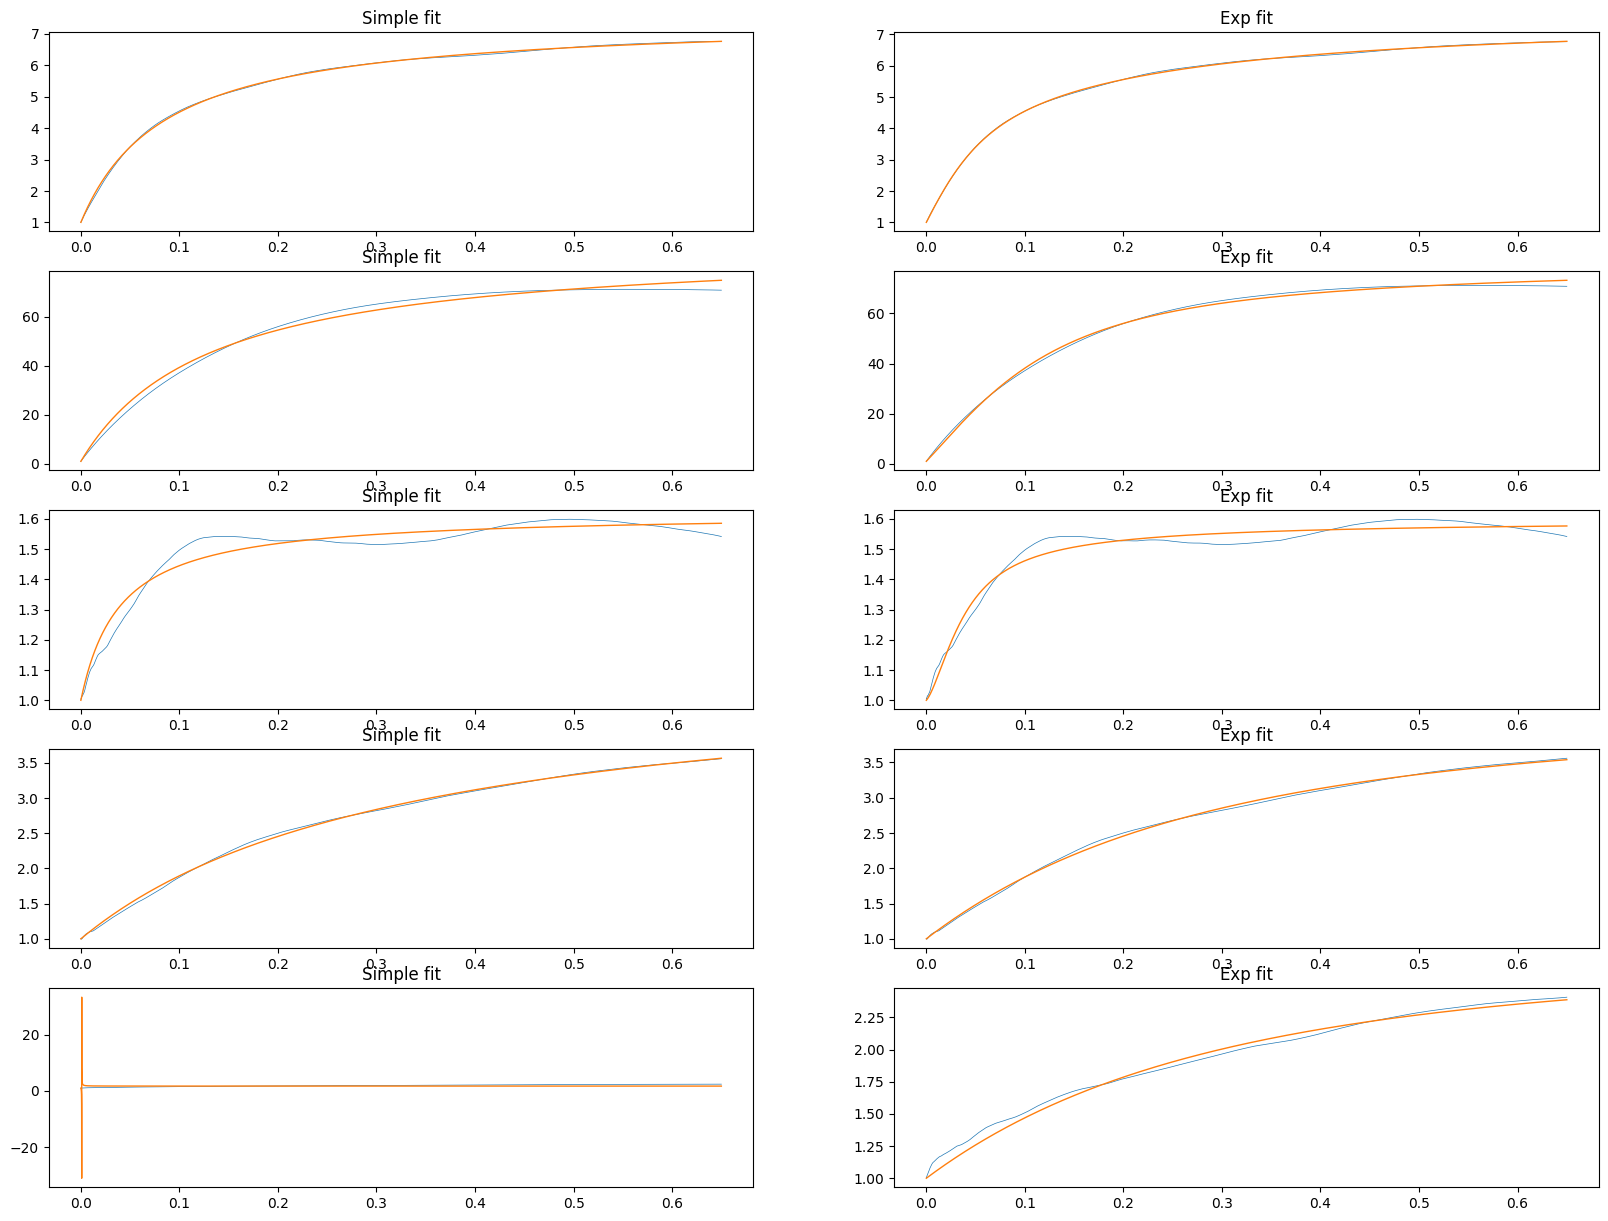

In [296]:
# Fit and plot s_redx
fig, ax = plt.subplots(5, 2, figsize=(20, 15))
ax = ax.ravel()

# p0=[1, 10, 10, 0.1, 0.1, 10]

for i in range(5):
    popt, pcov = curve_fit(fit_s_redx_simple, t_cxx, s_redx_list[i], p0=[1e3, 1e-2])
    popt2, pcov2 = curve_fit(fit_s_redx_exp, t_cxx, s_redx_list[i], p0=[1, 10, 10, 0.1, 0.01, 10],
                         bounds=([0, 0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]), maxfev=5000)
    print([round(p, 6) for p in popt2])
    
    ax[2*i].plot(t_cxx, s_redx_list[i], lw=0.5)
    ax[2*i].plot(t_cxx, fit_s_redx_simple(t_cxx, *popt), lw=1)
    ax[2*i].set_title("Simple fit")
    
    ax[2*i+1].plot(t_cxx, s_redx_list[i], lw=0.5)
    ax[2*i+1].plot(t_cxx, fit_s_redx_exp(t_cxx, *popt2), lw=1)
    ax[2*i+1].set_title("Exp fit")

In [280]:
def fit_cxx(t, a1, a2, a3, b1, b2, b3):
    return a1*np.exp(-b1*t) + a2*np.exp(-b2*t) + a3*np.exp(-b3*t)

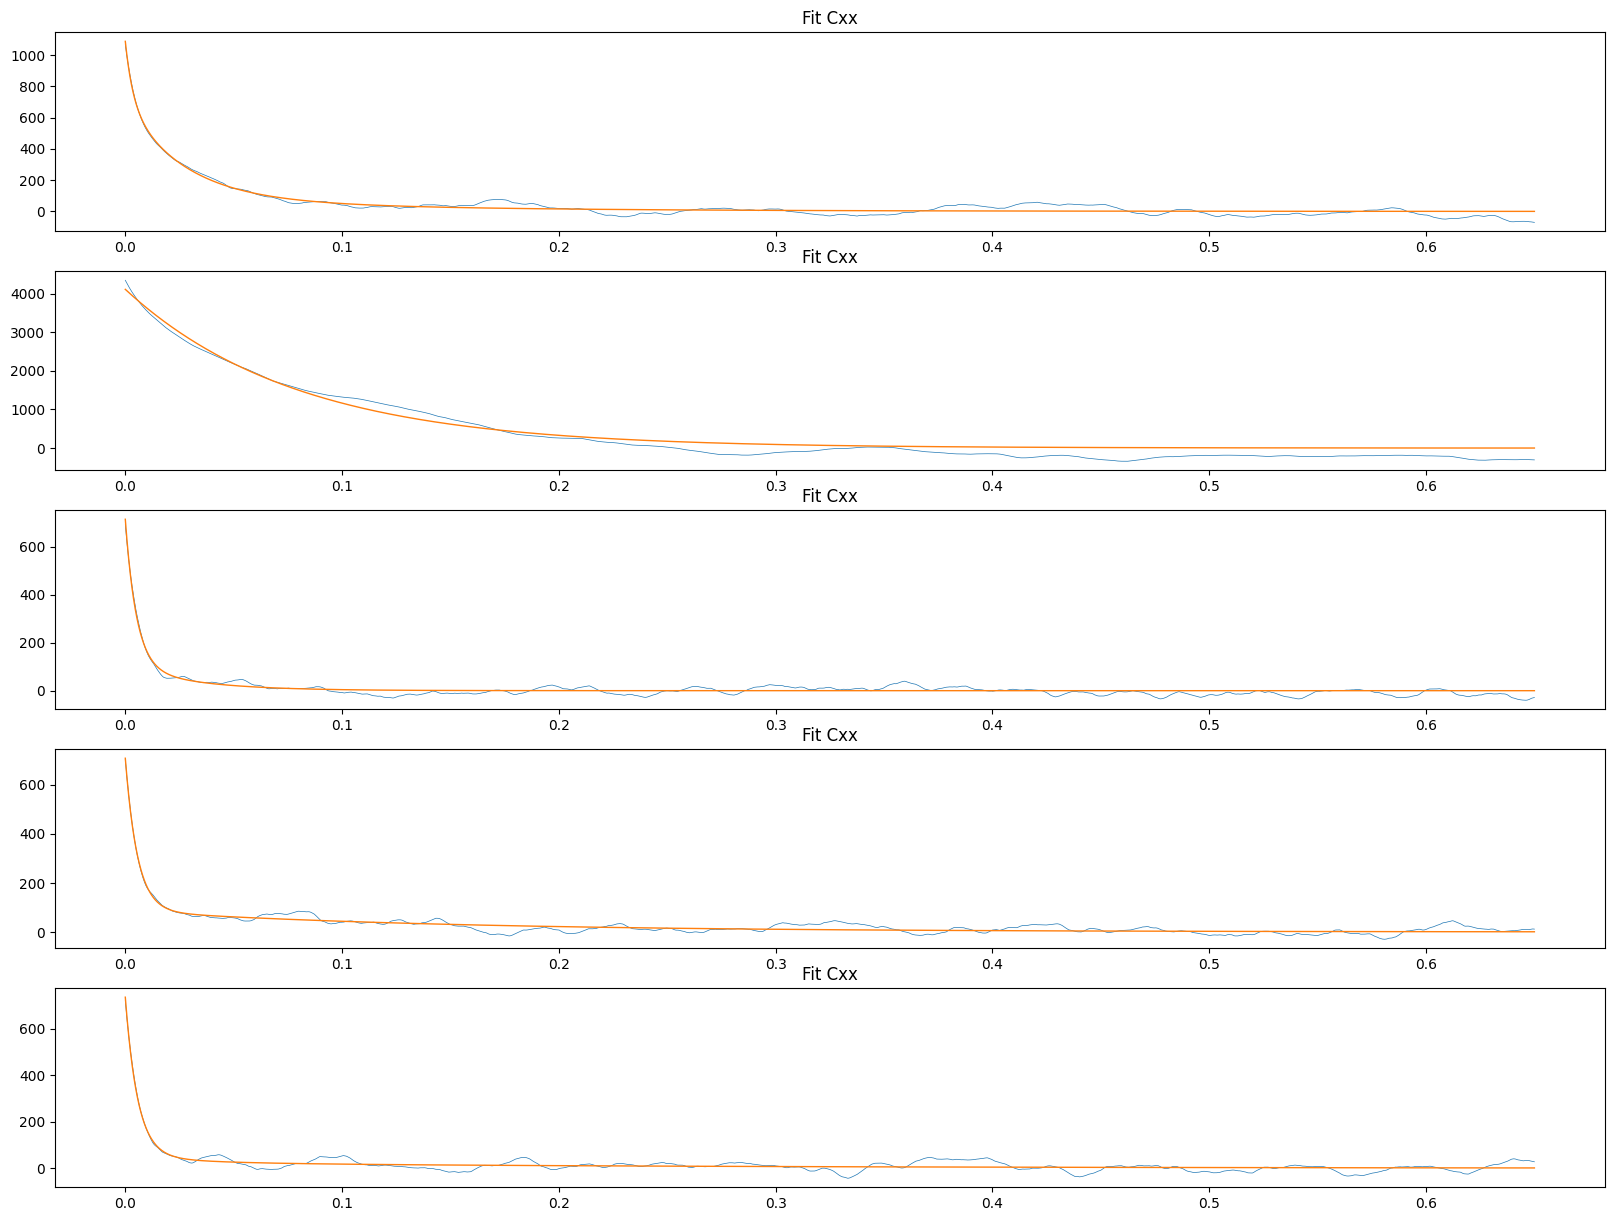

In [297]:
# Fit and plot Cxx
fig, ax = plt.subplots(5, 1, figsize=(20, 15))
ax = ax.ravel()

for i in range(5):
    popt, pcov = curve_fit(fit_cxx, t_cxx, Cxx_list[i], p0=[1, 1, 1, 1, 1, 1])
    ax[i].plot(t_cxx, Cxx_list[i], lw=0.5)
    ax[i].plot(t_cxx, fit_cxx(t_cxx, *popt), lw=1)
    ax[i].set_title("Fit Cxx")
